In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local[1]').appName('Accumulator').getOrCreate()

23/07/20 19:59:14 WARN Utils: Your hostname, OMEN resolves to a loopback address: 127.0.1.1; using 172.19.181.52 instead (on interface eth0)
23/07/20 19:59:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/20 19:59:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark

In [9]:
data = [
    ('India','India',5),
    ('India','China',7),
    ('China','India','three'),
    ('China','China',6),
    ('Japan','China','five')    
]
schema = 'source string, destination string, shipments string'

In [12]:
df = spark.createDataFrame(data, schema)

In [13]:
df.show()

+------+-----------+---------+
|source|destination|shipments|
+------+-----------+---------+
| India|      India|        5|
| India|      China|        7|
| China|      India|    three|
| China|      China|        6|
| Japan|      China|     five|
+------+-----------+---------+



In [14]:
from pyspark.sql import functions as F
from pyspark.sql import types as T

@F.udf(T.IntegerType())
def handle_bad_record(shipments: str) -> str:
    if shipments.isnumeric():
        return int(shipments)

In [15]:
df = df.withColumn('shipments_int', handle_bad_record('shipments'))

In [16]:
df.show()

+------+-----------+---------+-------------+
|source|destination|shipments|shipments_int|
+------+-----------+---------+-------------+
| India|      India|        5|            5|
| India|      China|        7|            7|
| China|      India|    three|         null|
| China|      China|        6|            6|
| Japan|      China|     five|         null|
+------+-----------+---------+-------------+



## Count the number of bad records:
#### We can get the count of null from the df

In [17]:
df.filter('shipments_int is null').count()

2

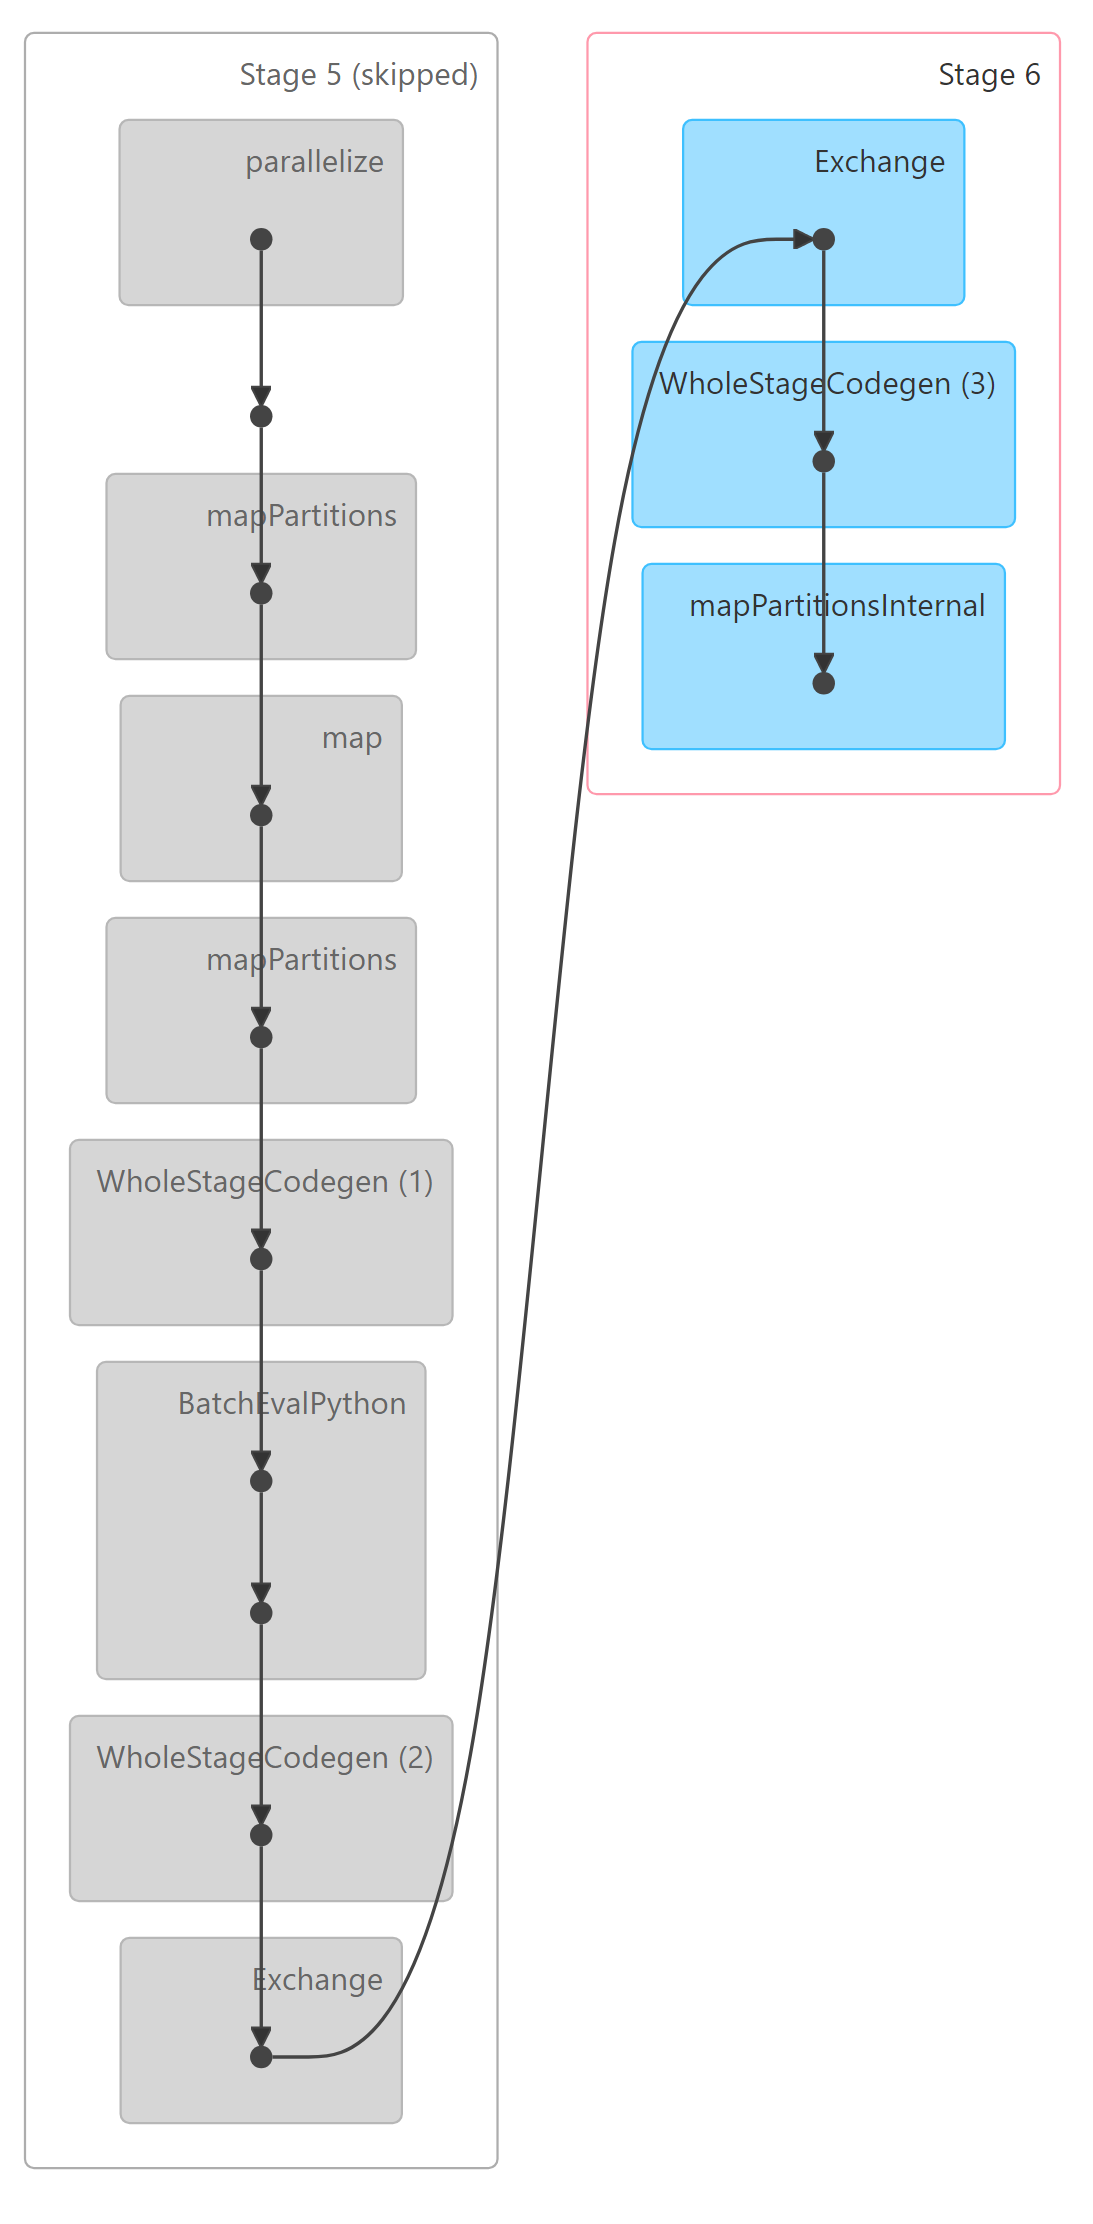

#### There is shuffle

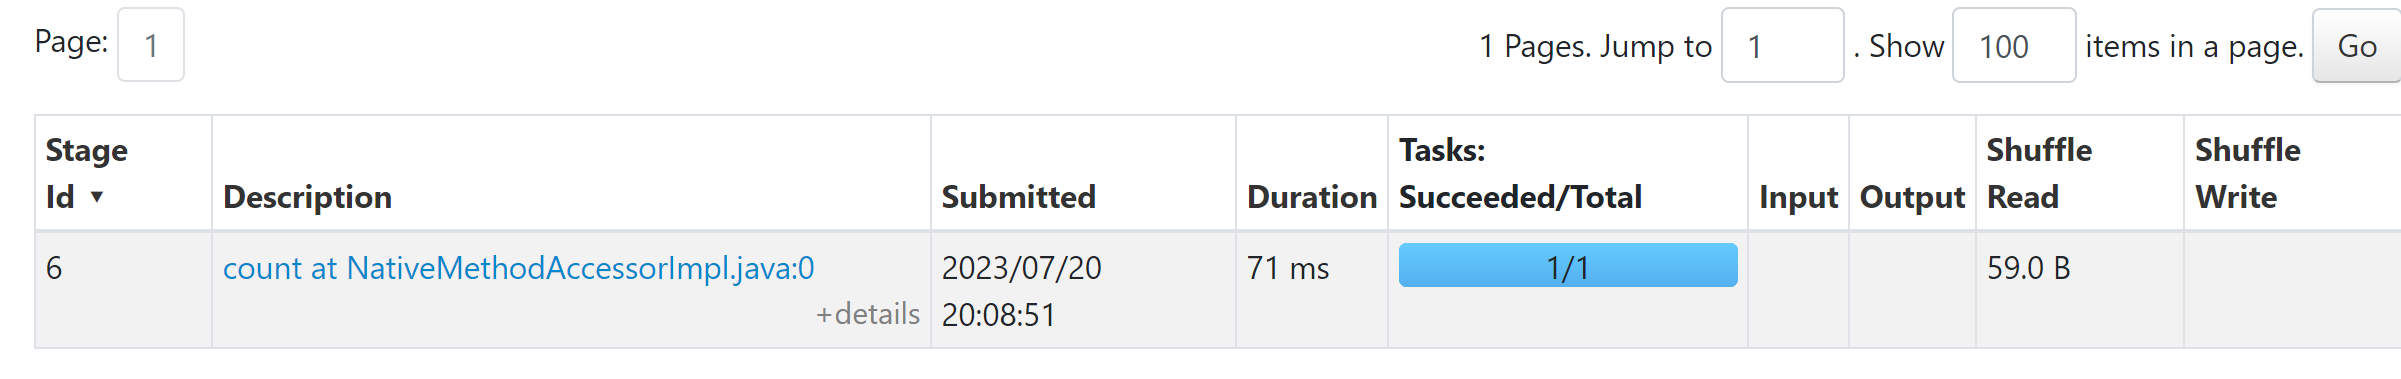

In [19]:
bad_record_count = spark.sparkContext.accumulator(0)

In [20]:
@F.udf(T.IntegerType())
def handle_bad_record_accumulator(shipments: str) -> str:
    if shipments.isnumeric():
        return int(shipments)
    else:
        bad_record_count.add(1)

In [22]:
df = df.withColumn('shipments_int1', handle_bad_record_accumulator('shipments'))

In [23]:
bad_record_count.value

0

In [24]:
df.show()

+------+-----------+---------+-------------+--------------+
|source|destination|shipments|shipments_int|shipments_int1|
+------+-----------+---------+-------------+--------------+
| India|      India|        5|            5|             5|
| India|      China|        7|            7|             7|
| China|      India|    three|         null|          null|
| China|      China|        6|            6|             6|
| Japan|      China|     five|         null|          null|
+------+-----------+---------+-------------+--------------+



In [25]:
bad_record_count.value

2

#### Value is updated on running the action

#### There is no shuffle of data involved

In [36]:
bad_record_count_action = spark.sparkContext.accumulator(0)

In [37]:
df.foreach(lambda record: bad_record_count_action.add(1) if record['shipments_int1'] is None else None)

In [38]:
bad_record_count_action.value

2